# Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# Download TF Models (Pretrained Models) from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tf-models-official 

In [ ]:
!pip install tensorflow-io

In [ ]:
!pip install scipy

In [ ]:
!pip install tensorflow==2.10.1 --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf==3.19.1 matplotlib==3.2

In [7]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# Create Label Map

### Label should have same name as object name in xml file.

In [ ]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Create TF records 
### for training a model, tensorflow dosen't understand or supports XML file, so running a script that converts the given XML files to TF records, which can be used for training 

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# Copy Model Config to Training Folder

### copying the pretrain configuration (pipeline file) to our training folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Training the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command) # command generated for training

In [ ]:
!{command}

# Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# Load Train Model From Checkpoint

### After training for some steps , the model is stored in  the checkpoint of each steps, and we are going to use the latest checkpoint (latest train data)

In [8]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [9]:
# ocr is build using pytorch so allocating some memory to tensorflow and pytorch on gpu.
# Prevent complete gpu consumption

gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # allocating 5gb for tensorflow on gpu
        tf.config.experimental.set_virtual_device_configuration(
            gpu[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunetimeError as e:
        print(e)
        

[]


In [10]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [13]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars412.png')

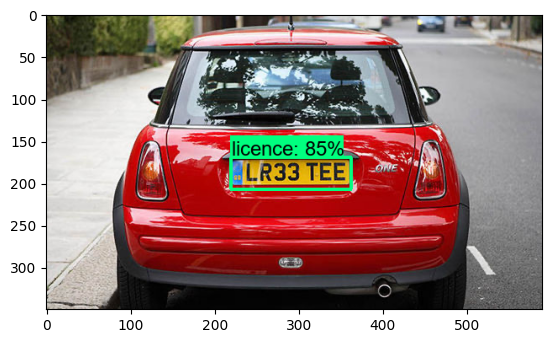

In [14]:
# detection happens here
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.6, # threshold for score (min 80% match)
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
detections.keys()

# Apply OCR to detection

In [ ]:
!pip install easyocr

In [ ]:
!pip3 install torch torchvision torchaudio

In [15]:
import easyocr

In [16]:
detection_threshold = 0.5

In [ ]:
image = image_np_with_detections  # grabbing image
scores = list(filter(lambda x: x > detection_threshold, detections['detection_scores']))  #extracting scores whose score is greater than threshold
boxes = detections['detection_boxes'][:len(scores)]  # filtering box coordinates (4 coordinates)
classes = detections['detection_classes'][:len(scores)] # filtering classes => 0 - represent license




In [ ]:
# detections['detection_scores'] > detection_threshold
# detections['detection_boxes'][:len(scores)]

In [ ]:
width = image.shape[1]
height = image.shape[0]

In [ ]:
# def dilateanderode(img):
#     kernel = np.ones((5,5),np.uint8)
#     img_erosion = cv2.erode(image,kernel,iteration=1)
#     return img_erosion
    
    

In [ ]:
# applying ROI Filtering and OCR
# boxes value represent coordinates of box without wrt to actual image size
for idx,box in enumerate(boxes):
    roi = box * [height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    
    # easy ocr setup
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    
#     img_gray = cv2.cvtColor(region,cv2.BGR2GRAY)
#     img_erosion = dilateanderode(img_gray)
#     plt.imshow(img_erosion)
    
    plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))

In [ ]:
val = ""
for result in ocr_result:
    val+= f"{result[1]} "
print(val)

# OCR Filtering

In [17]:
region_threshold = 0.1  # 60% of number plate 

In [18]:
# applying filtering to remove redundent texts on licence plate
def filter_text(region,ocr_result,region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    plate = []
    
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1],result[0][0]))
        height = np.sum(np.subtract(result[0][2],result[0][1]))
        print(length,height)
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

        
    
    

In [ ]:
filter_text(region,ocr_result,region_threshold)

# Combining above two functions

In [ ]:
# region_threshold = 0.5
# detection_threshold = 0.4

In [19]:
def ocr_it(image,detections,detection_threshold,region_threshold):
    # scores , boxes and classes above detection threshold
    scores = list(filter(lambda x: x > detection_threshold, detections['detection_scores']))  #extracting scores whose score is greater than threshold
    boxes = detections['detection_boxes'][:len(scores)]  # filtering box coordinates (4 coordinates)
    classes = detections['detection_classes'][:len(scores)] # filtering classes => 0 - represent license
    
    # image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # applying ROI filtering and OCR
    for idx,box in enumerate(boxes):
        roi = box * [height,width,height,width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]

        # easy ocr setup
        reader = easyocr.Reader(['en','hi','mr'])
        ocr_result = reader.readtext(region)
    #     print(ocr_result)
    
        text = filter_text(region,ocr_result,region_threshold)
        plt.imshow(cv2.cvtColor(region,cv2.COLOR_BGR2RGB))
        print(text)

        return text,region


126 30
['LR३३ TEE']


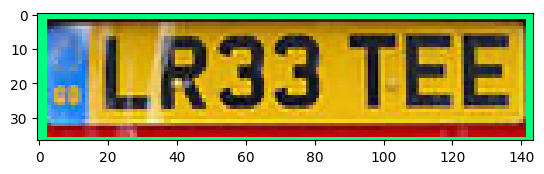

In [20]:
text,region = ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)

# Save Results

In [21]:
import csv
import uuid

In [22]:
def save_results(text,region,csv_filename,folder_path):
    img_name = f'{uuid.uuid1()}.jpg'
    
    cv2.imwrite(os.path.join(folder_path,img_name),region)
    
    with open(csv_filename,mode='a',newline='',encoding="utf-8") as f:
        csv_writer = csv.writer(f,delimiter=',',quotechar='"',quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name,text])
        
     

In [23]:
save_results(text,region,'detection_results.csv','Detection_Images')

# Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    try:
        text,region = ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)
        save_results(text,region,'realtime_results.csv','Detection_Images')
        plt.imshow(region)
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')